In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import gc
import re
import copy
import itertools
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob
import warnings
from IPython import display as ipd
warnings.filterwarnings("ignore")
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib.patches import Rectangle
import seaborn as sns
import random
from joblib import Parallel, delayed
import os, shutil
import datetime 
import holidays
import dateutil.easter as easter

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,SGDRegressor
from sklearn.model_selection import  GroupKFold,cross_val_score

from scipy.signal import savgol_filter


from matplotlib import pyplot
import missingno as msno
import plotly.express as px

import optuna



# <div style="background-color:#fff1cc; padding: 60px;"><center>⭐Feature Engineering + 📊EDA</center></div> 

# <div style="background-color:#fff1cc; padding: 20px;"><center>Import the Dataset</center></div> 

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e19/train.csv', parse_dates=['date'])
original_train_df = train_df.copy()
test_df = pd.read_csv('/kaggle/input/playground-series-s3e19/test.csv', parse_dates=['date'])
train_df.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [3]:
for df in [train_df, test_df]:
    df['product'] = df['product'].str.replace(' ', '_')
    df['product'] = df['product'].str.replace(':', '_')

In [4]:
test_df.head()

,id,date,country,store,product
0,136950,2022-01-01,Argentina,Kaggle Learn,Using_LLMs_to_Improve_Your_Coding
1,136951,2022-01-01,Argentina,Kaggle Learn,Using_LLMs_to_Train_More_LLMs
2,136952,2022-01-01,Argentina,Kaggle Learn,Using_LLMs_to_Win_Friends_and_Influence_People
3,136953,2022-01-01,Argentina,Kaggle Learn,Using_LLMs_to_Win_More_Kaggle_Competitions
4,136954,2022-01-01,Argentina,Kaggle Learn,Using_LLMs_to_Write_Better


# <div style="background-color:#fff1cc; padding: 20px;"><center>Explore the Dataset</center>
 </div>  

In [5]:
print('\n  country in the train dataset\n')
print(train_df['country'].value_counts())

print('\n  country in the test dataset\n')
print(test_df['country'].value_counts())

print('\n store in the train dataset\n')
print(train_df['store'].value_counts())

print('\n store in the test dataset\n')
print(test_df['store'].value_counts())

print('\n product in the train dataset\n')
print(train_df['product'].value_counts())

print('\n product in the test dataset\n')
print(test_df['product'].value_counts())


  country in the train dataset

Argentina    27390
Canada       27390
Estonia      27390
Japan        27390
Spain        27390
Name: country, dtype: int64

  country in the test dataset

Argentina    5475
Canada       5475
Estonia      5475
Japan        5475
Spain        5475
Name: country, dtype: int64

 store in the train dataset

Kaggle Learn    45650
Kaggle Store    45650
Kagglazon       45650
Name: store, dtype: int64

 store in the test dataset

Kaggle Learn    9125
Kaggle Store    9125
Kagglazon       9125
Name: store, dtype: int64

 product in the train dataset

Using_LLMs_to_Improve_Your_Coding                 27390
Using_LLMs_to_Train_More_LLMs                     27390
Using_LLMs_to_Win_Friends_and_Influence_People    27390
Using_LLMs_to_Win_More_Kaggle_Competitions        27390
Using_LLMs_to_Write_Better                        27390
Name: product, dtype: int64

 product in the test dataset

Using_LLMs_to_Improve_Your_Coding                 5475
Using_LLMs_to_Train_More_LLM

In [6]:
print("train min date:", train_df['date'].min())
print("train max date:", train_df['date'].max())
print("test min date:", test_df['date'].min())
print("test max date:", test_df['date'].max())

train min date: 2017-01-01 00:00:00
train max date: 2021-12-31 00:00:00
test min date: 2022-01-01 00:00:00
test max date: 2022-12-31 00:00:00


<Figure size 1500x600 with 0 Axes>

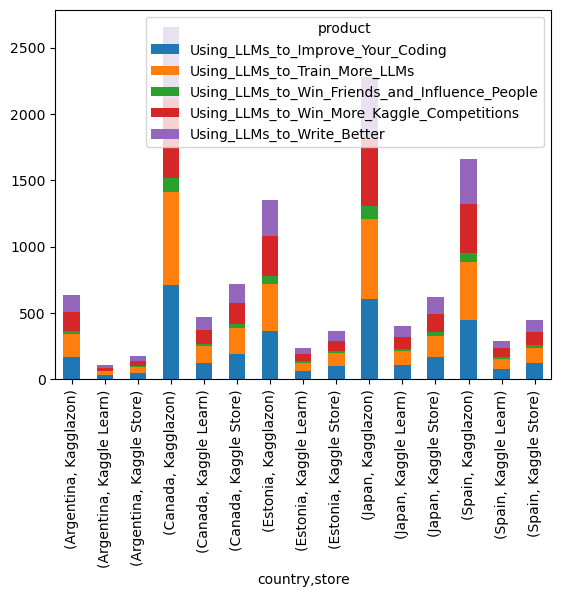

In [7]:
plt.figure(figsize=(15,6))
train_df.groupby(['country','store','product'])['num_sold'].mean().unstack().plot(kind='bar',stacked=True)
plt.show()

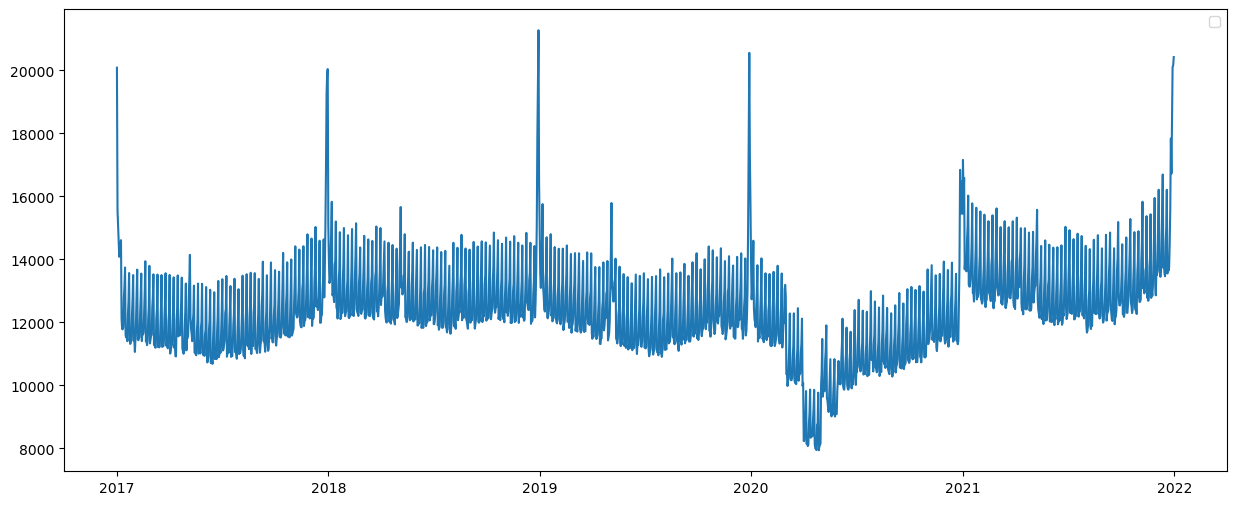

In [8]:
plt.figure(figsize=(15,6))
train_gp = train_df.groupby('date').sum().reset_index()
plt.plot(train_gp['date'], train_gp['num_sold'])
plt.legend()
plt.show()

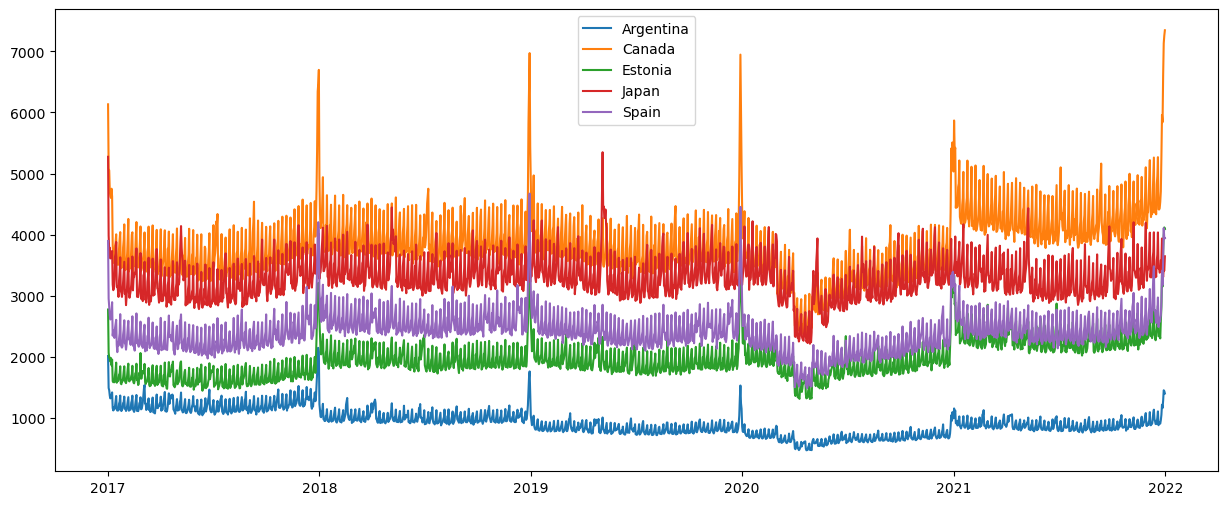

In [9]:
plt.figure(figsize=(15,6))
for country in train_df['country'].unique():
    filt_train = train_df[train_df['country'] == country]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=country)
plt.legend()
plt.show()

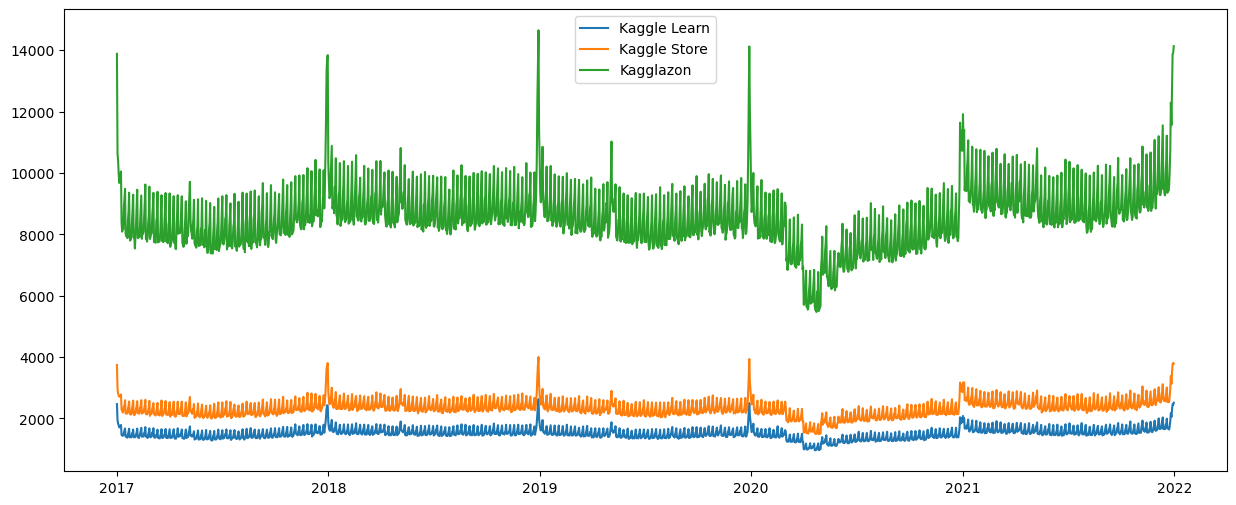

In [10]:
plt.figure(figsize=(15,6))
for store in train_df['store'].unique():
    filt_train = train_df[train_df['store'] == store]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=store)
plt.legend()
plt.show()

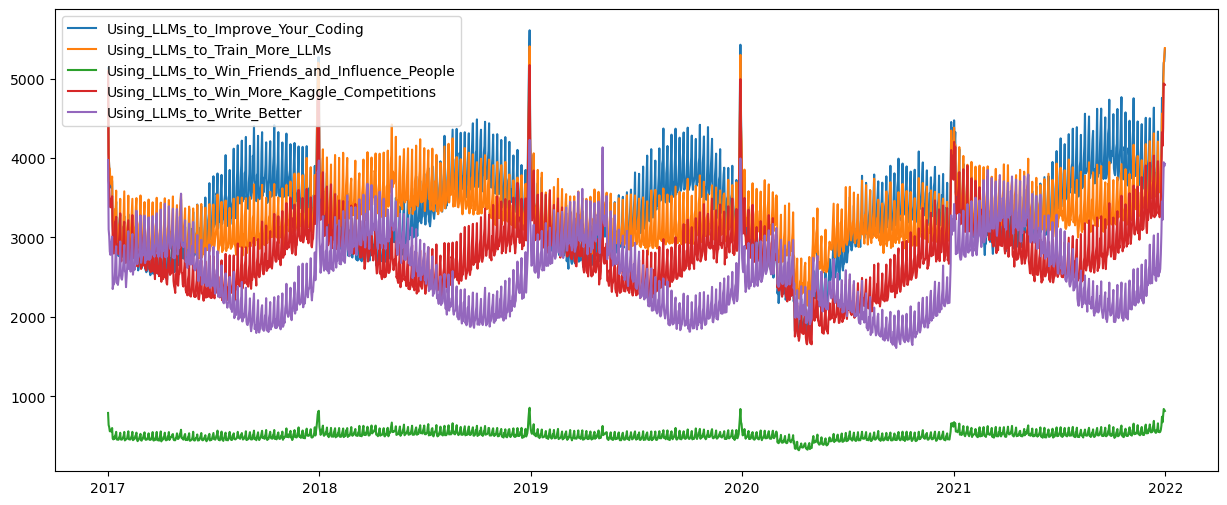

In [11]:
plt.figure(figsize=(15,6))
for product in train_df['product'].unique():
    filt_train = train_df[train_df['product'] == product]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=product)
plt.legend()
plt.show()

In [12]:
weekly_df = train_df.groupby(["country","store", "product", pd.Grouper(key="date", freq="W")])["num_sold"].sum().rename("num_sold").reset_index()
monthly_df = train_df.groupby(["country","store", "product", pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()

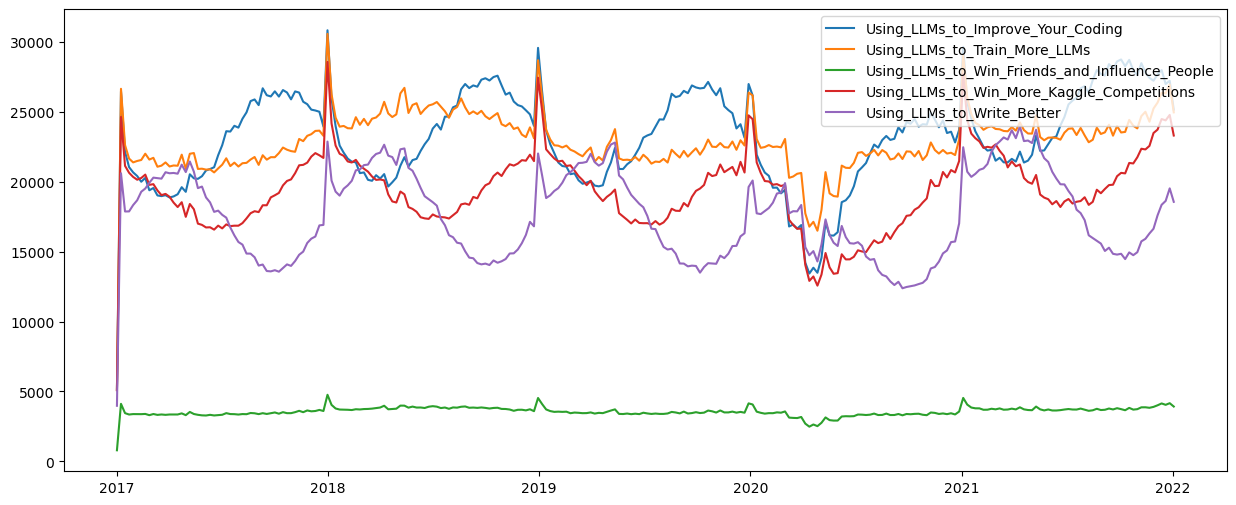

In [13]:
plt.figure(figsize=(15,6))
for product in train_df['product'].unique():
    filt_train = weekly_df[weekly_df['product'] == product]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=product)
plt.legend()
plt.show()

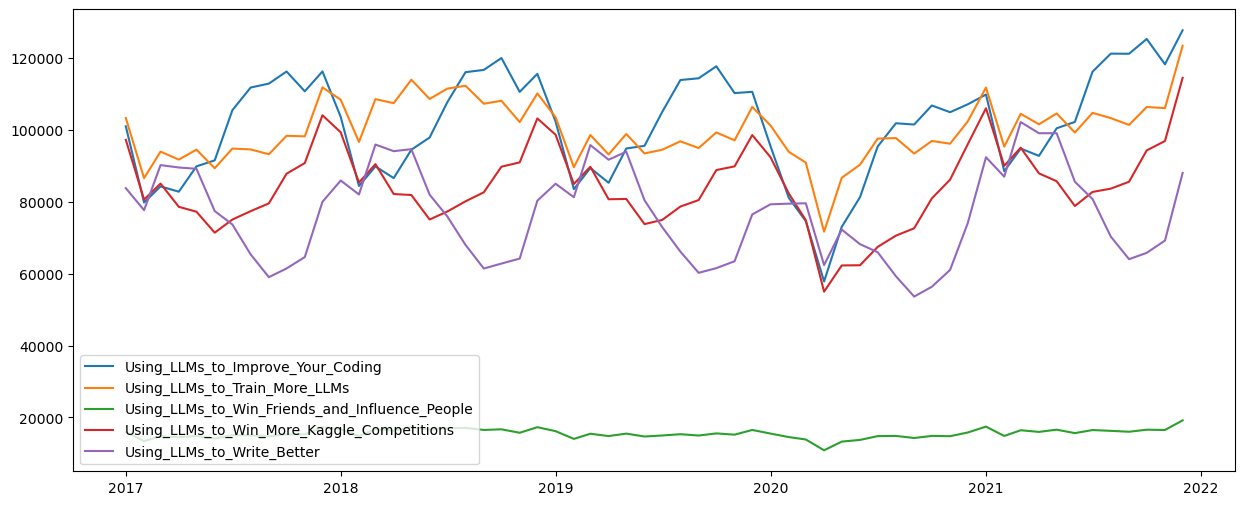

In [14]:
plt.figure(figsize=(15,6))
for product in train_df['product'].unique():
    filt_train = monthly_df[monthly_df['product'] == product]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=product)
plt.legend()
plt.show()

In [15]:
product_store_weights = monthly_df.groupby(["product","store"])["num_sold"].sum() / monthly_df.groupby(["product"])["num_sold"].sum()
product_store_weights

product                                         store       
Using_LLMs_to_Improve_Your_Coding               Kagglazon       0.690540
                                                Kaggle Learn    0.121816
                                                Kaggle Store    0.187644
Using_LLMs_to_Train_More_LLMs                   Kagglazon       0.690639
                                                Kaggle Learn    0.121786
                                                Kaggle Store    0.187575
Using_LLMs_to_Win_Friends_and_Influence_People  Kagglazon       0.694905
                                                Kaggle Learn    0.119164
                                                Kaggle Store    0.185931
Using_LLMs_to_Win_More_Kaggle_Competitions      Kagglazon       0.690928
                                                Kaggle Learn    0.121533
                                                Kaggle Store    0.187539
Using_LLMs_to_Write_Better                      Kagglazon      

In [16]:
store_weights = train_df.groupby("store")["num_sold"].sum()/train_df["num_sold"].sum()
store_weights

store
Kagglazon       0.690891
Kaggle Learn    0.121576
Kaggle Store    0.187533
Name: num_sold, dtype: float64

In [17]:
new_monthly_df = monthly_df.loc[monthly_df["date"] < "2020-01-01"]
product_country_weights = new_monthly_df.groupby(["product","country"])["num_sold"].sum() / new_monthly_df.groupby(["product"])["num_sold"].sum()
product_country_weights

product                                         country  
Using_LLMs_to_Improve_Your_Coding               Argentina    0.081451
                                                Canada       0.306095
                                                Estonia      0.149519
                                                Japan        0.266212
                                                Spain        0.196723
Using_LLMs_to_Train_More_LLMs                   Argentina    0.081333
                                                Canada       0.305833
                                                Estonia      0.149559
                                                Japan        0.266735
                                                Spain        0.196540
Using_LLMs_to_Win_Friends_and_Influence_People  Argentina    0.080137
                                                Canada       0.307360
                                                Estonia      0.149166
                                

In [18]:
product_df = train_df.groupby(["date","product"])["num_sold"].sum().reset_index()
product_df.head()

,date,product,num_sold
0,2017-01-01,Using_LLMs_to_Improve_Your_Coding,5131
1,2017-01-01,Using_LLMs_to_Train_More_LLMs,5103
2,2017-01-01,Using_LLMs_to_Win_Friends_and_Influence_People,791
3,2017-01-01,Using_LLMs_to_Win_More_Kaggle_Competitions,5086
4,2017-01-01,Using_LLMs_to_Write_Better,3975


In [19]:
product_ratio_df = product_df.pivot(index="date", columns="product", values="num_sold")
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
product_ratio_df = product_ratio_df.stack().rename("ratios").reset_index()
product_ratio_df.head(4)

,date,product,ratios
0,2017-01-01,Using_LLMs_to_Improve_Your_Coding,0.255452
1,2017-01-01,Using_LLMs_to_Train_More_LLMs,0.254058
2,2017-01-01,Using_LLMs_to_Win_Friends_and_Influence_People,0.039381
3,2017-01-01,Using_LLMs_to_Win_More_Kaggle_Competitions,0.253211


In [20]:
product_ratio_df.tail()

,date,product,ratios
9125,2021-12-31,Using_LLMs_to_Improve_Your_Coding,0.263001
9126,2021-12-31,Using_LLMs_to_Train_More_LLMs,0.263686
9127,2021-12-31,Using_LLMs_to_Win_Friends_and_Influence_People,0.039957
9128,2021-12-31,Using_LLMs_to_Win_More_Kaggle_Competitions,0.241015
9129,2021-12-31,Using_LLMs_to_Write_Better,0.192342


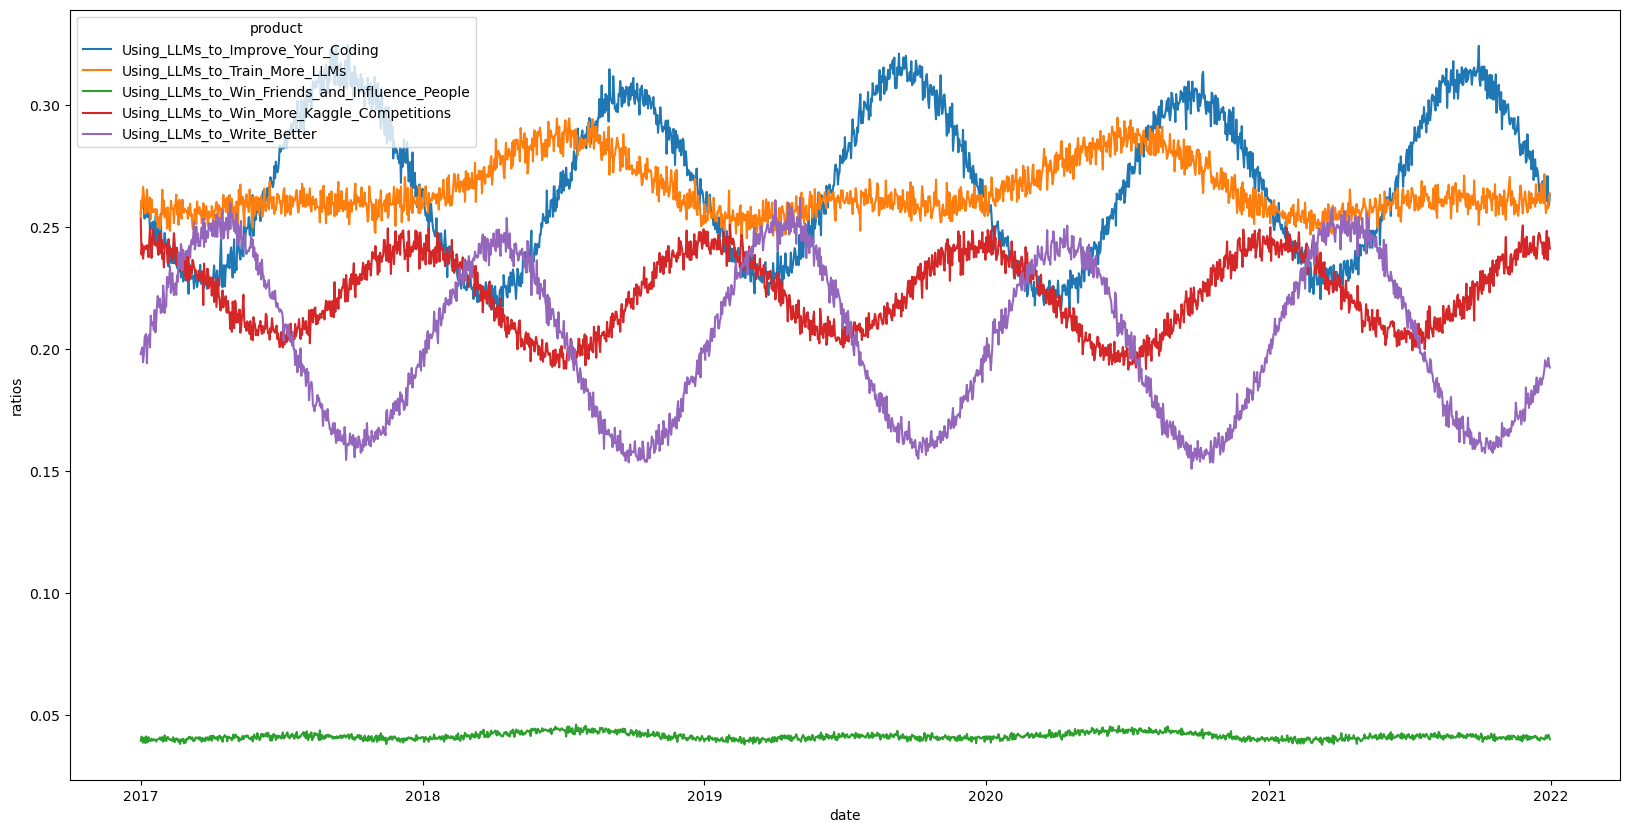

In [21]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = product_ratio_df, x="date", y="ratios", hue="product");

# <div style="background-color:#fff1cc; padding: 20px;"><center> Feature Engineering</center>
 </div>  

In [22]:
train_df = train_df.groupby(["date"])["num_sold"].sum().reset_index()

In [23]:
weekly_df = train_df.groupby([pd.Grouper(key="date", freq="W")])["num_sold"].sum().rename("num_sold").reset_index()
monthly_df = train_df.groupby([pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()

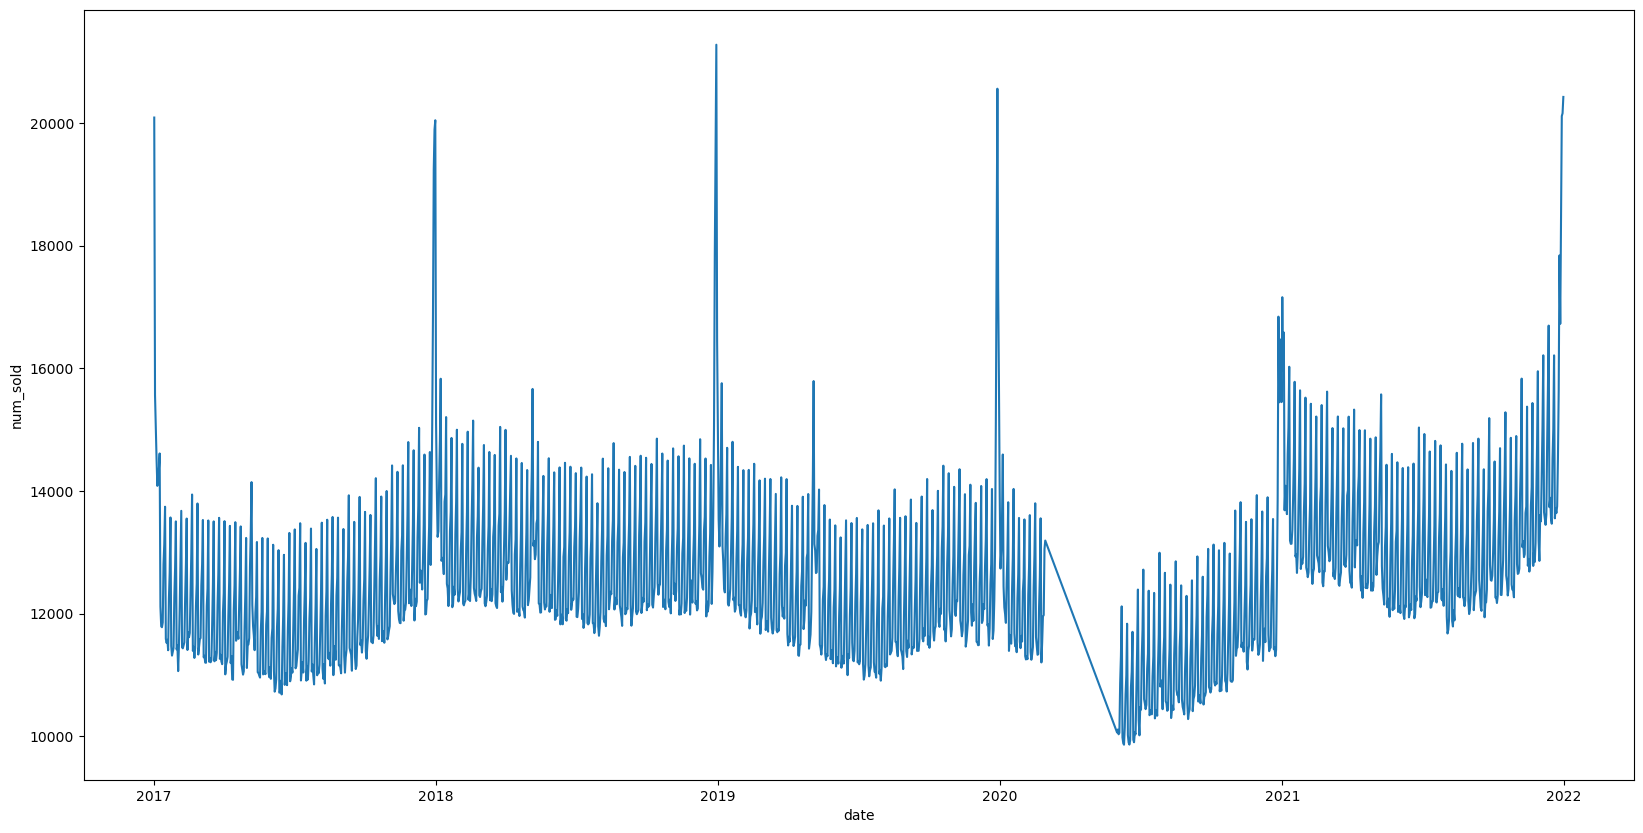

In [24]:
train_nocovid_df = train_df.loc[~((train_df["date"] >= "2020-03-01") & (train_df["date"] < "2020-06-01"))]
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train_nocovid_df, x="date", y="num_sold");

In [25]:
train_df = train_nocovid_df

#get the dates to forecast for
test_all_df = test_df.groupby(["date"])["id"].first().reset_index().drop(columns="id")
#keep dates for later
test_all_df_dates = test_all_df[["date"]]

In [26]:
def feature_engineer(df):
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * np.pi / 24)
    new_df["month_cos"] = np.cos(new_df['month'] * np.pi / 24)
    
    new_df["day"] = df["date"].dt.day
    #new_df["day_sin"] = np.sin(new_df['day'] * (2 * np.pi / 12))
    new_df["day_sin"] = np.sin(new_df['day'] * np.pi / 62)
    
    new_df["day_of_week"] = df["date"].dt.dayofweek
    new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))
    
    new_df['friday'] = new_df.date.dt.weekday.eq(4).astype(np.uint8)
    new_df['saturday'] = new_df.date.dt.weekday.eq(5).astype(np.uint8)
    new_df['sunday'] = new_df.date.dt.weekday.eq(6).astype(np.uint8)
    
    new_df["day_of_year"] = df["date"].dt.dayofyear

    new_df["day_of_year"] = new_df.apply(lambda x: x["day_of_year"]-1 if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] < pd.Timestamp("2021-01-01"))  else x["day_of_year"], axis=1)
    
    important_dates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,16,17, 124, 125, 126, 127, 140, 141,142, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179,
                  180, 181, 203, 230, 231, 232, 233, 234, 282, 289, 290, 307, 308, 309, 310, 311, 312, 313, 317, 318, 319, 320, 360, 361, 362, 363, 364, 365]
    

    new_df["important_dates"] = new_df["day_of_year"].apply(lambda x: x if x in important_dates else 0)
    
    new_df["year"] = df["date"].dt.year - 2016
    
    easter_date = new_df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))

    for day in list(range(-5, 5)) + list(range(40, 48)):
        new_df[f'easter_{day}'] = (new_df.date - easter_date).dt.days.eq(day)
        
    for col in new_df.columns :
        if 'easter' in col :
            new_df = pd.get_dummies(new_df, columns = [col], drop_first=True)
            
    for day in range(24, 32):
        new_df[f'Dec_{day}'] = new_df.date.dt.day.eq(day) & new_df.date.dt.month.eq(12)
        
        
    new_df = new_df.drop(columns=["date","month","day", "day_of_year"])
    new_df = pd.get_dummies(new_df, columns = ["important_dates","day_of_week"], drop_first=True)
    
    return new_df

In [27]:
def get_holidays(df):
    years_list = [2017, 2018, 2019, 2020, 2021]

    holiday_BE = holidays.CountryHoliday('BE', years = years_list)
    holiday_FR = holidays.CountryHoliday('FR', years = years_list)
    holiday_DE = holidays.CountryHoliday('DE', years = years_list)
    holiday_IT = holidays.CountryHoliday('IT', years = years_list)
    holiday_PL = holidays.CountryHoliday('PL', years = years_list)
    holiday_ES = holidays.CountryHoliday('ES', years = years_list)

    holiday_dict = holiday_BE.copy()
    holiday_dict.update(holiday_FR)
    holiday_dict.update(holiday_DE)
    holiday_dict.update(holiday_IT)
    holiday_dict.update(holiday_PL)
    holiday_dict.update(holiday_ES)

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    
    return df

In [28]:
train_all_df = get_holidays(train_df)
test_all_df = get_holidays(test_all_df)

In [29]:
train_all_df = feature_engineer(train_all_df)
test_all_df = feature_engineer(test_all_df)

In [30]:
train_all_df['num_sold'] = np.log(train_all_df['num_sold'])

In [31]:
display(train_all_df.head(2))
display(test_all_df.head(2))

,num_sold,holiday_name,is_holiday,month_sin,month_cos,day_sin,friday,saturday,sunday,year,...,important_dates_320,important_dates_360,important_dates_361,important_dates_362,important_dates_363,important_dates_364,important_dates_365,day_of_week_1,day_of_week_2,day_of_week_3
0,9.907778,Capodanno; New Year's Day; Nieuwjaarsdag,1,0.130526,0.991445,0.050649,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
1,9.652652,Año nuevo (Trasladado),1,0.130526,0.991445,0.101168,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


,holiday_name,is_holiday,month_sin,month_cos,day_sin,friday,saturday,sunday,year,easter_-5_True,...,important_dates_320,important_dates_360,important_dates_361,important_dates_362,important_dates_363,important_dates_364,important_dates_365,day_of_week_1,day_of_week_2,day_of_week_3
0,Not Holiday,0,0.130526,0.991445,0.050649,0,1,0,6,0,...,0,0,0,0,0,0,0,0,1,0
1,Not Holiday,0,0.130526,0.991445,0.101168,0,0,1,6,0,...,0,0,0,0,0,0,0,0,0,1
